# Prediccion del precio de las viviendas mediante regresion lineal

En este script de realizara la prediccion mediantes metodos de regresion

# Librerias

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, KFold , cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error , r2_score , mean_absolute_error , explained_variance_score
import warnings
warnings.filterwarnings("ignore")

# Datos

In [57]:
dfp=pd.read_csv(r'C:\Users\Juan Guzman\pviviendas\Data\dfanalisis')
dfp.head()

,tipo,precio,area,habitaciones,banos,garajes,balcon,trans. publico,estrato,antiguedad,...,zonas verdes,supermercado o cc,instalacion de gas,parqueadero visitantes,colegios / universidades,parques cercanos,zona residencial,closet,municipio,tipo_propiedad
0,0,1380000000,320.00,5,6.0,2,1.0,1.0,5.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,rionegro,casa
1,1,496122600,91.97,3,3.0,1,1.0,1.0,3.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,rionegro,apartamento
2,0,570000000,150.00,3,3.0,1,1.0,1.0,5.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,san antonio de pereira,casa
3,0,290000000,106.00,3,3.0,1,0.0,0.0,4.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,marinilla,casa
4,1,360002000,73.37,3,3.0,0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,rionegro,apartamento


# Procesamiento de los datos


Primero dividiremos la variable objetivo que seria el precio de las variables explicativas que serian todas las demas

In [58]:
V_numeric = ['area','habitaciones','banos','garajes']
y = dfp['precio']
X_categoric = dfp.drop(['area','habitaciones','banos','garajes','precio'],axis=1)
X_numeric = dfp[V_numeric]


In [59]:
X_categoric.shape , X_numeric.shape

((2144, 18), (2144, 4))

## Procesamiento de variables numericas

para la regresión lineal múltiple, se recomienda que las variables predictoras y la variable objetivo tengan una distribución normal y que la relación entre ellas sea lineal. Si estas condiciones no se cumplen, se pueden aplicar transformaciones a las variables para mejorar la precisión del modelo.

Debido a que las distribuciones de las variables tienen comportamiento muy variados unas de otras se optara por estandarizar la variable lo que significa centrar  la variable en $0$ y con una desviación estándar de $1$:

$$X^{\prime} = \frac{X - \mu}{\sigma}$$


In [60]:
scaler = StandardScaler() # declaramos el transformador
X_numeric_est = scaler.fit_transform(X_numeric)

## Procesamiento de variables categoricas

haremos el procesamiento mediante OneHotEncoder, el cual se asemeja al tratamiento de una variable dummi, es decir, para cada categoria se le asignara 1 si corresponde a esa categoria y 0 para las demas

In [61]:
enc = OneHotEncoder(sparse=False)
X_categoric_onehot = enc.fit_transform(X_categoric)
X_categoric.shape , X_categoric_onehot.shape

((2144, 18), (2144, 52))

Ahora procederemos a unir los dos conjuntos de datos en la variable X

In [62]:
X = np.concatenate((X_numeric_est,X_categoric_onehot),axis=1)
dfp.shape , X.shape

((2144, 23), (2144, 56))

Se puede observar la gran cantidad de clases que tenemos en el dataset

# Particion de los datos

Para este caso dividiremos los datos de la siguiente manera:
* 60% entrenamiento
* 20% test
* 20%validacion

Debido a que la regreison lineal no permite modificar muchos hiperparametros no entramos en la necesidad de utilizar un porcentaje de los datos para validar.
Con el fin de realizar un buen entrenamiento del algoritmo y mejorar su capacidad predictiva

In [63]:
# Primera división en train y test (80% y 20% respectivamente)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

# Segunda división en train y validación (60% y 20% respectivamente)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=1234)

print(f"Conjunto de entrenamiento: {X_train.shape[0]}, {y_train.shape[0]}, en porcentaje correspone a {round(((X_train.shape[0]/X.shape[0])*100),0)} del total de la muestra")
print(f"Conjunto de validación: {X_val.shape[0]}, {y_val.shape[0]}, en porcentaje correspone a {round(((X_val.shape[0]/X.shape[0])*100),0)} del total de la muestra")
print(f"Conjunto de prueba: {X_test.shape[0]}, {y_test.shape[0]}, en porcentaje correspone a {round(((X_test.shape[0]/X.shape[0])*100),0)} del total de la muestra")


Conjunto de entrenamiento: 1286, 1286, en porcentaje correspone a 60.0 del total de la muestra
Conjunto de validación: 429, 429, en porcentaje correspone a 20.0 del total de la muestra
Conjunto de prueba: 429, 429, en porcentaje correspone a 20.0 del total de la muestra


# Modelo

## Regresion lineal 

In [64]:
linear = LinearRegression()
linear.get_params()

{'copy_X': True,
 'fit_intercept': True,
 'n_jobs': None,
 'normalize': 'deprecated',
 'positive': False}

In [65]:
# validacion cruzada
param_grid_linear = {'fit_intercept': [True, False],
                    'normalize': [True, False],
                    'copy_X': [True, False],
                    'positive': [True, False]
}
gridlinear = GridSearchCV(linear, param_grid_linear, cv=5) # cv son las divisiones de la validacion cruzada
# entrenamiento del modelo
gridlinear.fit(X_train,y_train)
print(gridlinear.best_params_)
print(gridlinear.best_estimator_)

{'copy_X': True, 'fit_intercept': False, 'normalize': True, 'positive': True}
LinearRegression(fit_intercept=False, normalize=True, positive=True)


## Regresion Ridge

In [66]:
ridge = Ridge(random_state=42)
ridge.get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'normalize': 'deprecated',
 'positive': False,
 'random_state': 42,
 'solver': 'auto',
 'tol': 0.001}

In [67]:
param_grid_ridge = {
    'alpha': [0.1,1.0,10.0],
    'fit_intercept': [True,False],
    'normalize': [True,False],
    'copy_X': [True,False],
    'solver':['auto','svd','cholesky','lsqr','sparse_cg'],
}
gridridge = GridSearchCV(ridge, param_grid_ridge, cv=5)
# entrenamiento del modelo
gridridge.fit(X_train,y_train)
print(gridridge.best_params_)
print(gridridge.best_estimator_)

{'alpha': 0.1, 'copy_X': True, 'fit_intercept': True, 'normalize': True, 'solver': 'svd'}
Ridge(alpha=0.1, normalize=True, random_state=42, solver='svd')


## Regresion Lasso

In [68]:
lasso = Lasso(random_state=42)
lasso.get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': 1000,
 'normalize': 'deprecated',
 'positive': False,
 'precompute': False,
 'random_state': 42,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

In [69]:
param_grid_lasso = {
   'alpha': [0.1, 1.0, 10.0],
   'fit_intercept': [True, False],
   'normalize': [True, False],
   'copy_X': [True, False],
   'selection': ['cyclic', 'random']
}
gridlasso = GridSearchCV(lasso, param_grid_lasso, cv=5)
# entrenamiento del modelo
gridlasso.fit(X_train,y_train)
print(gridlasso.best_params_)
print(gridlasso.best_estimator_)

{'alpha': 10.0, 'copy_X': True, 'fit_intercept': True, 'normalize': True, 'selection': 'cyclic'}
Lasso(alpha=10.0, normalize=True, random_state=42)


# Evaluacion del modelo

In [70]:
def metrics(model, y_true, X_val, model_name):
    y_est = model.predict(X_val)
    r2 = r2_score(y_true, y_est)
    mse = mean_squared_error(y_true, y_est)
    absolutemse = mean_absolute_error(y_true, y_est)
    rmse = np.sqrt(mean_squared_error(y_true, y_est))
    ev = explained_variance_score(y_true, y_est)
    results = {'R2': round(r2, 4), 'MSE': round(mse, 4), 'RMSE': round(rmse, 4), 'AbsoluteMSE': round(absolutemse, 4), 'ExplainedVariance': round(ev, 4)}
    df = pd.DataFrame.from_dict(results, orient='index', columns=[model_name]).transpose()
    df.index.name = 'model_name'
    return df

In [71]:
metric_linear = metrics(gridlinear,y_val,X_val,'linear')
metric_lasso = metrics(gridlasso,y_val,X_val,'lasso')
metric_ridge =metrics(gridridge,y_val,X_val,'ridge')
dfmetrics = pd.concat([metric_linear,metric_lasso,metric_ridge])
dfmetrics

,R2,MSE,RMSE,AbsoluteMSE,ExplainedVariance
model_name,,,,,
linear,0.6446,8.354692e+16,2.890448e+08,2.008730e+08,0.6455
lasso,0.6395,8.476834e+16,2.911500e+08,2.042423e+08,0.6404
ridge,0.6427,8.399870e+16,2.898253e+08,2.021198e+08,0.6435


In [72]:
dfmetrics[['MSE','RMSE','AbsoluteMSE']].idxmin()


MSE            linear
RMSE           linear
AbsoluteMSE    linear
dtype: object

In [73]:
dfmetrics[['R2','ExplainedVariance']].idxmax()


R2                   linear
ExplainedVariance    linear
dtype: object

# Modelo final

Se selecciona el modelo lineal, debido a que presenta las mejores metricas de evaluacion.
A continuacion se uniran los datos de entreno y validacion con el fin de tener mayores datos de entrenamiento y probas el modelo con los datos de prueba para ver su error de generalizacion

In [74]:
# Unimos los datos de train y validation
X_train_val = np.concatenate((X_train, X_val), axis=0)
y_train_val = np.concatenate((y_train, y_val), axis=0)
print(X_train_val.shape)
print(y_train_val.shape)

(1715, 56)
(1715,)


In [83]:
# modelo lineal
linear = LinearRegression(fit_intercept=False, normalize=True, positive=True)
linear.fit(X_train_val,y_train_val)

LinearRegression(fit_intercept=False, normalize=True, positive=True)

In [84]:
metric_linear_test = metrics(linear,y_test,X_test,'linear_new')
metric_linear_test

,R2,MSE,RMSE,AbsoluteMSE,ExplainedVariance
model_name,,,,,
linear_new,0.6473,1.025940e+17,3.203029e+08,2.171681e+08,0.6503


In [85]:
# comparamos las metricas en validacion y en test
linear_comparacion = pd.concat([metric_linear_test,metric_linear])
# los valores de la primera fila corresponden a el modelo probado con los datos de test
linear_comparacion

,R2,MSE,RMSE,AbsoluteMSE,ExplainedVariance
model_name,,,,,
linear_new,0.6473,1.025940e+17,3.203029e+08,2.171681e+08,0.6503
linear,0.6446,8.354692e+16,2.890448e+08,2.008730e+08,0.6455


In [86]:
y_pred_linear = linear.predict(X_test)


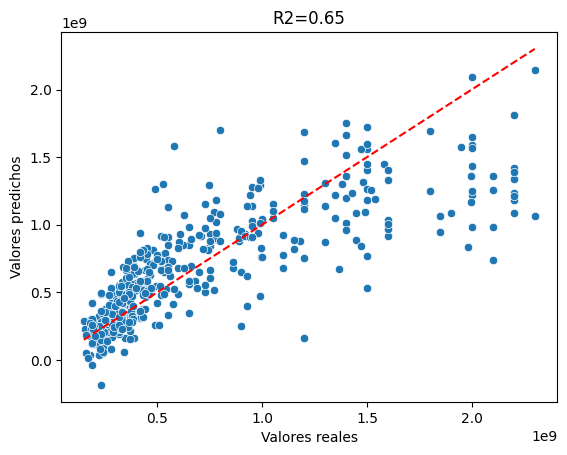

In [87]:
sns.scatterplot(x=y_test, y=y_pred_linear)
sns.lineplot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], color='r', linestyle='--')
plt.xlabel('Valores reales')
plt.ylabel('Valores predichos')
plt.title(f'R2={r2_score(y_test, y_pred_linear):.2f}')
plt.show()

Esta grafica muestra los valores reales en el eje x y los valores predichos por el modelo en el eje y. La linea roja punteada representa una prediccion perfecta, es decir, en la que los valores reales y predichos coinciden. Ademas se muestra el coeficiente de determiancion R2 , que indica cuanto varian los valores predichos en funcion de los valores reales

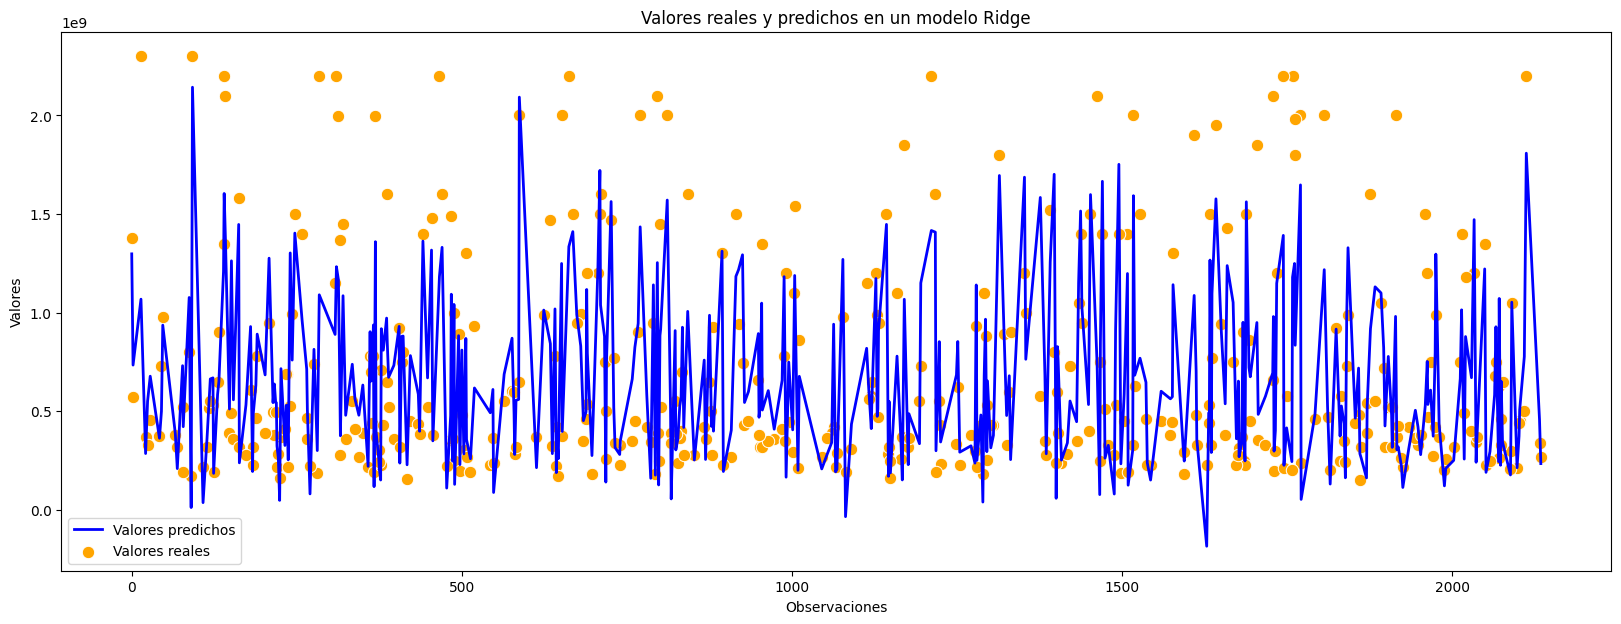

In [88]:
plt.figure(figsize=(20, 7))
df_grafica_test = pd.DataFrame({'Valores reales': y_test, 'Valores predichos': y_pred_linear})

sns.lineplot(x=df_grafica_test.index, y='Valores predichos', data=df_grafica_test, linewidth=2, color='blue')
sns.scatterplot(x=df_grafica_test.index, y='Valores reales', data=df_grafica_test,  s=80, color='orange')
plt.title('Valores reales y predichos en un modelo Ridge')
plt.xlabel('Observaciones')
plt.ylabel('Valores')
plt.legend(labels=['Valores predichos', 'Valores reales'])

# Conclusion - Modelos Lineales

En el análisis de los modelos lineales seleccionados, se encontró que el modelo lineal fue el que mejor explicó los datos. A través de la validación cruzada, se encontraron sus hiperparámetros, y se determinó que los mejores hiperparámetros son: fit_intercept=False, normalize=True, positive=True.

Las métricas de evaluación de este modelo sobre los datos fuera de muestra son las siguientes:

* R2: 0.6473
* MSE: 1.025940e+17
* RMSE: 3.203029e+08
* AbsoluteMSE: 2.171681e+08	
* Varianza explicada: 0.6503

Se observa que el modelo mejoro con los datos fuera de muestra aunque en un proporcion demasiado mimina.Mediante las graficas de evaluacion se observo como este moddelo no captura muy bien los valores atipicos y es demasiado flexible o suave (subajuste). Por lo tanto se utilizaran otros modelos de con el fin de observar diferentes enfoques y buscar modelos que presenten mejores metricas de evaluacion.